In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scanpy as sc

adata = sc.read_h5ad("Visium_Human_Breast_Cancer_filtered_feature_bc_matrix.h5ad")

adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

train_df = pd.read_csv("train_edges.csv")
valid_df = pd.read_csv("val_edges.csv")
test_df = pd.read_csv("test_edges.csv").drop('label', axis=1)

lr_pairs = pd.read_csv('celltalk_human_lr_pair.txt', sep='\t')

print("Train shape:", train_df.shape)
print("Valid shape:", valid_df.shape)
print("Test shape:", test_df.shape)
print("LR Pairs shape:", lr_pairs.shape)

Train shape: (12000, 3)
Valid shape: (4000, 3)
Test shape: (4000, 2)
LR Pairs shape: (3398, 10)


In [5]:
adata

AnnData object with n_obs × n_vars = 4898 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [7]:
lr_pairs.head()

,lr_pair,ligand_gene_symbol,receptor_gene_symbol,ligand_gene_id,receptor_gene_id,ligand_ensembl_protein_id,receptor_ensembl_protein_id,ligand_ensembl_gene_id,receptor_ensembl_gene_id,evidence
0,SEMA3F_PLXNA3,SEMA3F,PLXNA3,6405,55558,ENSP00000002829,ENSP00000358696,ENSG00000001617,ENSG00000130827,15721238
1,SEMA3F_PLXNA1,SEMA3F,PLXNA1,6405,5361,ENSP00000002829,ENSP00000377061,ENSG00000001617,ENSG00000114554,26156437
2,SEMA3F_NRP1,SEMA3F,NRP1,6405,8829,ENSP00000002829,ENSP00000265371,ENSG00000001617,ENSG00000099250,9883722
3,SEMA3F_NRP2,SEMA3F,NRP2,6405,8828,ENSP00000002829,ENSP00000353582,ENSG00000001617,ENSG00000118257,15721238
4,CX3CL1_CX3CR1,CX3CL1,CX3CR1,6376,1524,ENSP00000006053,ENSP00000351059,ENSG00000006210,ENSG00000168329,"10699158,24218476"


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import numpy as np
import pandas as pd

expr_matrix = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X
gene_to_idx = {gene: idx for idx, gene in enumerate(adata.var_names)}

def extract_features(cell_data):
    feature_data = []
    
    for _, row in tqdm(cell_data.iterrows(), total=len(cell_data), desc="Extracting features"):
        source_cell = row['source']
        target_cell = row['target']
        
        source_expr = expr_matrix[source_cell]
        target_expr = expr_matrix[target_cell]
        
        features = {}
        
        # 配体-受体特征
        for _, lr_row in lr_pairs.iterrows():
            ligand_gene = lr_row['ligand_gene_symbol']
            receptor_gene = lr_row['receptor_gene_symbol']
            
            if ligand_gene in gene_to_idx and receptor_gene in gene_to_idx:
                ligand_idx = gene_to_idx[ligand_gene]
                receptor_idx = gene_to_idx[receptor_gene]
                
                ligand_expr = source_expr[ligand_idx]
                receptor_expr = target_expr[receptor_idx]
                
                lr_prefix = f"{ligand_gene}_{receptor_gene}"
                
                features.update({
                    f"{lr_prefix}_ligand": ligand_expr,
                    f"{lr_prefix}_receptor": receptor_expr,
                    f"{lr_prefix}_product": ligand_expr * receptor_expr,
                    f"{lr_prefix}_mean": (ligand_expr + receptor_expr) / 2,
                    f"{lr_prefix}_ratio": ligand_expr / (receptor_expr + 1e-6),
                    f"{lr_prefix}_diff": ligand_expr - receptor_expr,
                })
        
        feature_data.append(features)
    
    feature_data = pd.DataFrame(feature_data)
    
    return feature_data

In [ ]:
print("Extract features...")
feature_data = extract_features(train_df)
X = feature_data
y = train_df['label']


print("Train randomforest classifier...")
model = RandomForestClassifier(random_state=50)
model.fit(X, y)

Extract features...


Extracting features: 100%|██████████| 12000/12000 [16:01<00:00, 12.48it/s]


Train randomforest classifier...


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Visualization...


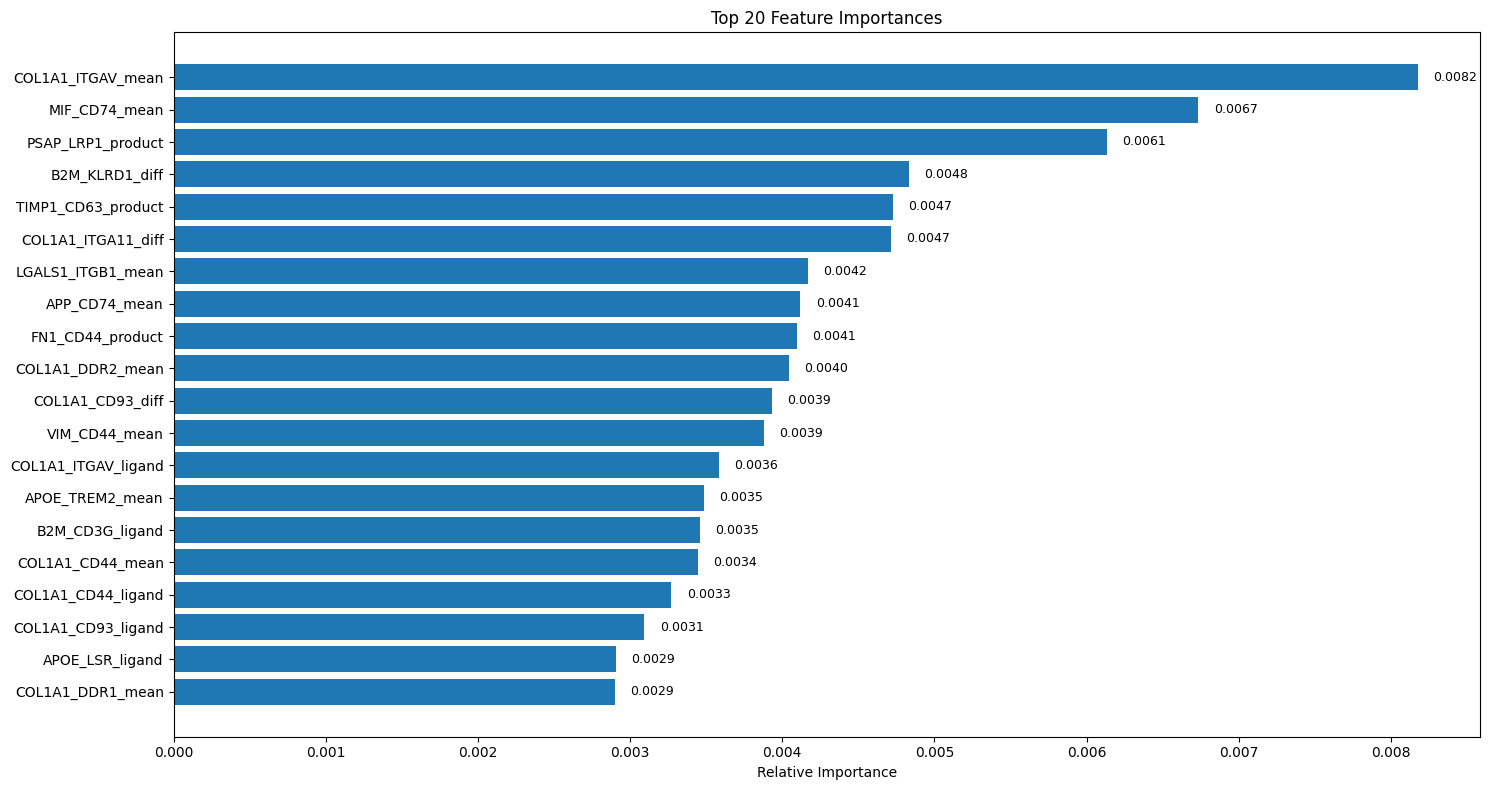

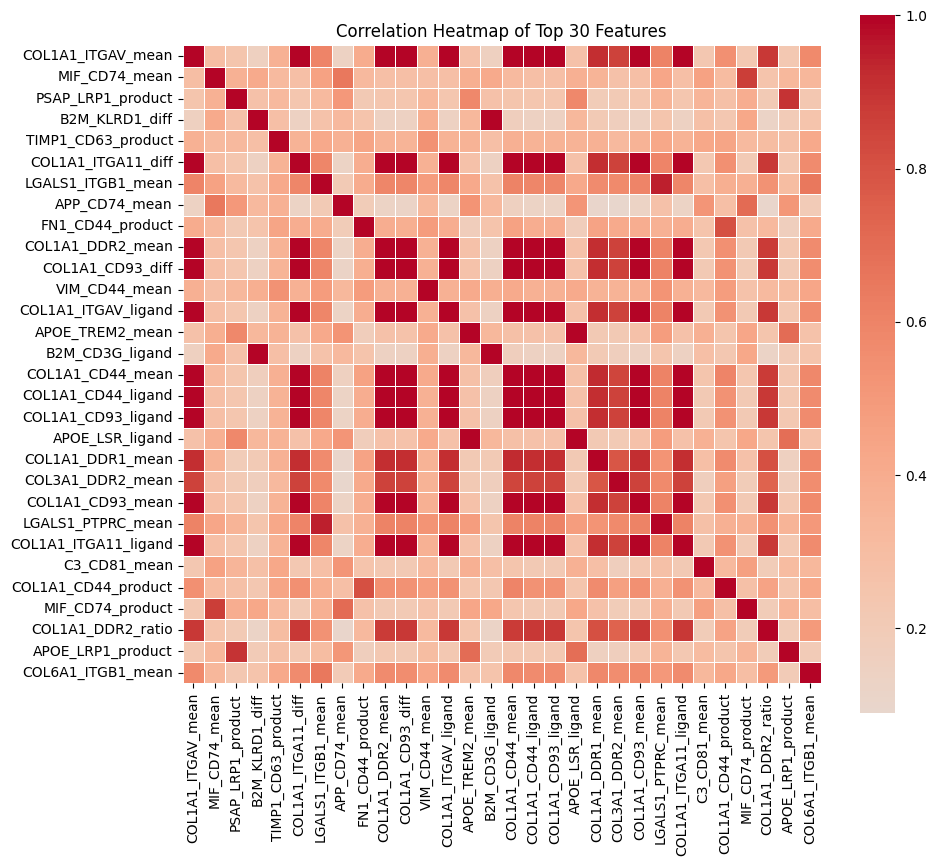

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns


def plot_feature_importance(model, feature_names, top_n=20, figsize=(15, 8)):
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]
    
    plt.figure(figsize=figsize)
    plt.title(f'Top {top_n} Feature Importances')

    bars = plt.barh(range(top_n), importance[indices[:top_n]][::-1])
    plt.yticks(range(top_n), [feature_names[i] for i in indices[:top_n]][::-1])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    
    for _, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.0001, bar.get_y() + bar.get_height()/2,
                f'{width:.4f}', ha='left', va='center', fontsize=9)
    
    return plt


def plot_feature_correlation(feature_data, top_n=30, figsize=(10, 10)):
    importance = model.feature_importances_
    top_indices = np.argsort(importance)[-top_n:][::-1]
    top_features = feature_data.columns[top_indices]
    
    corr_matrix = feature_data[top_features].corr()
    
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, 
                square=True, linewidths=.5, cbar_kws={"shrink": .8})
    plt.title(f'Correlation Heatmap of Top {top_n} Features')
    plt.tight_layout()
    
    return plt


print("Visualization...")

feature_names = X.columns.tolist()

# 特征重要性
plt1 = plot_feature_importance(model, feature_names, top_n=20)
plt1.show()

# 特征相关性
plt2 = plot_feature_correlation(X, top_n=30)
plt2.show()